In [1]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

In [2]:
import pandas as pd
from ml.utils import get_data_for_columns

N_DAYS_LAG = 7
def get_historic_data(path="../../data/merged.csv"):
    lags = list(range(1, N_DAYS_LAG + 1)) + [14]
    baseline_columns = [f"water_level_cm_151160060_{i}" for i in lags]

    data, y = get_data_for_columns(baseline_columns, path)
    return y

data = get_historic_data()
data

water_level_cm_151160060
date                                
2012-01-01                     199.0
2012-01-02                     197.0
2012-01-03                     197.0
2012-01-04                     204.0
2012-01-05                     205.0
...                              ...
2020-12-27                     290.0
2020-12-28                     266.0
2020-12-29                     264.0
2020-12-30                     254.0
2020-12-31                     245.0

[3288 rows x 1 columns]

In [3]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(data)

<AxesSubplot: xlabel='date'>

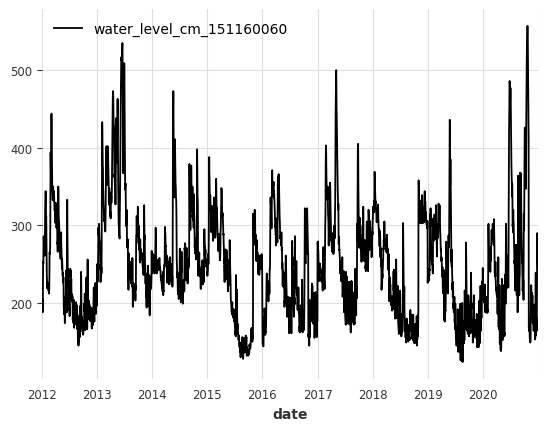

In [4]:
data.plot()

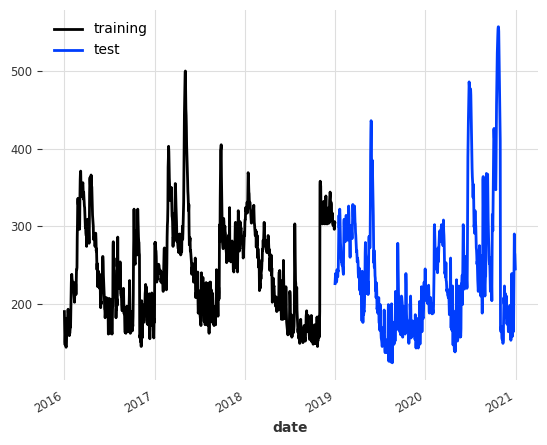

In [5]:
train, test = series.split_before(pd.Timestamp("20190101"))
train = train.slice(pd.Timestamp("20160101"), pd.Timestamp("20190101"))
train.plot(label="training")
test.plot(label="test")

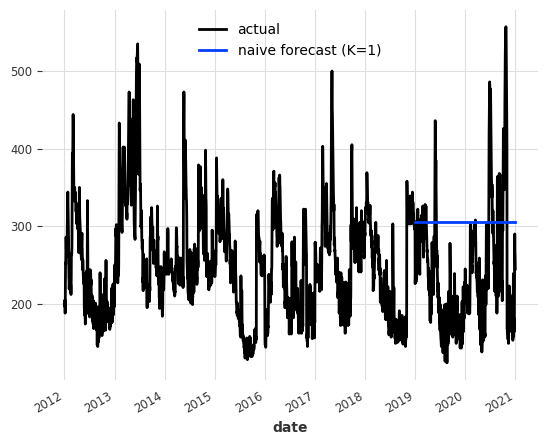

In [6]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(365 * 2)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

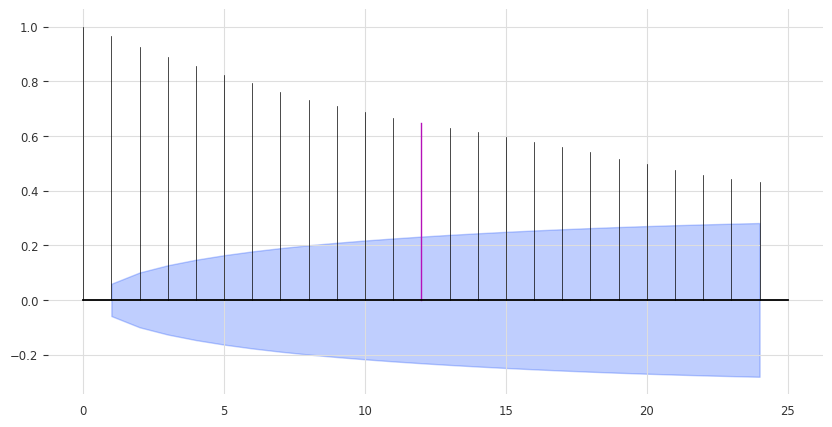

In [7]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

In [8]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

Mean absolute error for the combined naive drift + seasonal: 117.62


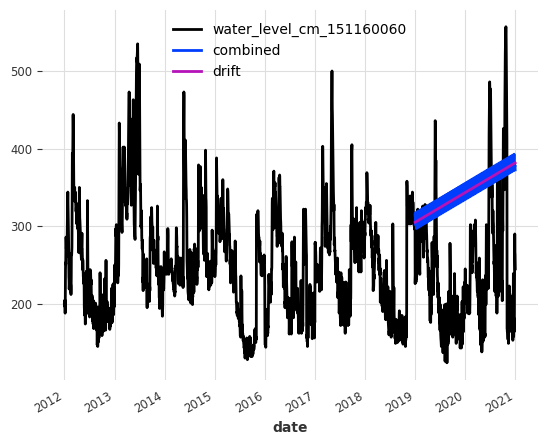

In [9]:
from darts.models import NaiveDrift

seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(365 * 2)


drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(365 * 2)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")


# MAP
from darts.metrics import mae, mse, mape

print(
    "Mean absolute error for the combined naive drift + seasonal: {:.2f}".format(
        mae(series, combined_forecast)
    )
)

In [10]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(test))
    print("model {} obtains MAE: {:.2f}".format(model, mae(test, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 obtains MAE: 286.41
model (T)BATS obtains MAE: 91.85
model Auto-ARIMA obtains MAE: 61.46
model Theta(2) obtains MAE: 75.97


In [11]:
import numpy as np

# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(test))
    res = mae(test, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(test))

print(
    "The MAE is: {:.2f}, with theta = {}.".format(
        mae(test, pred_best_theta), best_theta
    )
)

The MAE is: 70.99, with theta = -0.24489795918367463.


  0%|          | 0/718 [00:00<?, ?it/s]

MAE = 52.07


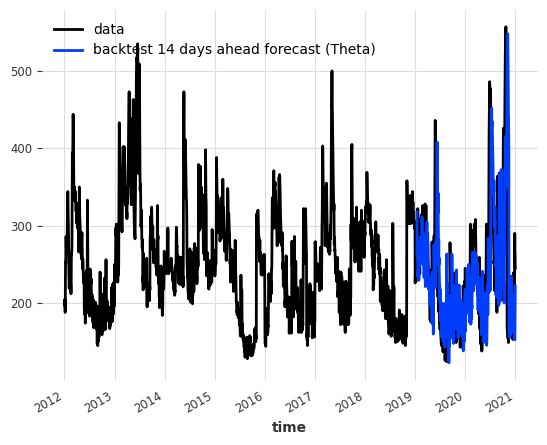

In [12]:
# BACKTESTING FOR BEST THETA MODEL

historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=pd.Timestamp("20190101"), forecast_horizon=14, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 14 days ahead forecast (Theta)")
print("MAE = {:.2f}".format(mae(historical_fcast_theta, series)))

In [29]:
from tqdm import tqdm
from darts.metrics import mae, mse, mape

test_from_date = pd.Timestamp("20190101")
model = AutoARIMA()
maes = []
mapes = []
r2s = []
mses = []

for i in tqdm(range(52)):
    train, test = series.split_before(pd.Timestamp(test_from_date))

    model.fit(train)
    forecast = model.predict(14)
    print(max(forecast.values()), min(forecast.values()), mae(test, forecast))
    maes.append(mae(test, forecast))
    mapes.append(mape(test, forecast))
    mses.append(mse(test, forecast))
    test_from_date += pd.Timedelta(days=14)

print(test_from_date)
print("MAE = {:.2f}".format(np.mean(maes)))
print("MAPE = {:.2f}".format(np.mean(mapes)))
print("MSE = {:.2f}".format(np.mean(mses)))

  2%|▏         | 1/52 [00:13<11:46, 13.86s/it]

[303.48049777] [296.95374533] 64.07598660507666


  4%|▍         | 2/52 [00:28<11:51, 14.23s/it]

[252.54744078] [242.30175347] 37.062081094735596


  6%|▌         | 3/52 [00:40<10:47, 13.22s/it]

[262.2529028] [254.90754622] 19.982577461034886


  8%|▊         | 4/52 [00:54<10:55, 13.66s/it]

[279.63843797] [276.69156918] 18.482114273851103


 10%|▉         | 5/52 [01:07<10:32, 13.47s/it]

[331.04445226] [310.35896716] 28.502507047507606


 12%|█▏        | 6/52 [01:20<10:11, 13.29s/it]

[283.00575937] [282.77151417] 29.522168018904352


 13%|█▎        | 7/52 [01:32<09:41, 12.93s/it]

[290.7436122] [289.5404276] 32.51964102808917


 15%|█▌        | 8/52 [01:45<09:28, 12.93s/it]

[257.00613546] [240.55276666] 27.567863942412554


 17%|█▋        | 9/52 [01:59<09:28, 13.23s/it]

[246.30907052] [234.63191599] 37.37389357234895


 19%|█▉        | 10/52 [02:12<09:04, 12.97s/it]

[259.55163896] [255.53384719] 25.642352130372746


 21%|██        | 11/52 [02:24<08:47, 12.86s/it]

[274.8327917] [263.73182099] 90.28180373463297


 23%|██▎       | 12/52 [02:38<08:44, 13.12s/it]

[338.89618384] [315.1314203] 73.13813387363486


 25%|██▌       | 13/52 [02:52<08:42, 13.39s/it]

[237.53388276] [213.94275379] 35.809184801195066


 27%|██▋       | 14/52 [03:05<08:18, 13.13s/it]

[200.45888448] [166.08228114] 30.362467976796896


 29%|██▉       | 15/52 [03:17<08:01, 13.01s/it]

[191.97904999] [167.75942635] 29.377134355327062


 31%|███       | 16/52 [03:31<07:56, 13.23s/it]

[172.73972435] [150.63277715] 18.05940910221021


 33%|███▎      | 17/52 [03:44<07:40, 13.14s/it]

[194.81470474] [193.33443727] 39.81534331672804


 35%|███▍      | 18/52 [03:55<07:02, 12.43s/it]

[159.6679058] [148.21498998] 23.33361898188462


 37%|███▋      | 19/52 [04:07<06:47, 12.34s/it]

[171.40303891] [167.73027106] 33.93843844714068


 38%|███▊      | 20/52 [04:19<06:35, 12.35s/it]

[171.25185753] [162.56378638] 16.529056963696018


 40%|████      | 21/52 [04:30<06:09, 11.93s/it]

[177.83327507] [174.3993074] 13.674830386601547


 42%|████▏     | 22/52 [04:42<05:59, 11.98s/it]

[178.7901794] [175.27121254] 12.207365868013968


 44%|████▍     | 23/52 [04:55<05:52, 12.15s/it]

[186.24352625] [184.24113827] 19.648023777727758


 46%|████▌     | 24/52 [05:08<05:52, 12.60s/it]

[169.06288723] [163.69765236] 10.680643958235848


 48%|████▊     | 25/52 [05:28<06:38, 14.75s/it]

[165.53070867] [160.51767104] 15.375897002481596


 50%|█████     | 26/52 [05:39<05:54, 13.63s/it]

[183.2367523] [177.99219581] 18.19489910077035


 52%|█████▏    | 27/52 [05:50<05:20, 12.84s/it]

[206.93155424] [194.9402387] 11.316779267937564


 54%|█████▍    | 28/52 [06:00<04:49, 12.05s/it]

[209.35424948] [200.99443179] 8.832995267410295


 56%|█████▌    | 29/52 [06:12<04:31, 11.80s/it]

[191.47980411] [189.98283737] 34.73203999044763


 58%|█████▊    | 30/52 [06:24<04:24, 12.01s/it]

[262.73600256] [237.76220964] 8.875100484387632


 60%|█████▉    | 31/52 [06:35<04:05, 11.70s/it]

[260.90272987] [244.15995573] 37.729122656839316


 62%|██████▏   | 32/52 [06:46<03:50, 11.51s/it]

[293.63945746] [273.58394083] 16.91656030759905


 63%|██████▎   | 33/52 [06:58<03:38, 11.50s/it]

[247.08865088] [241.59822325] 26.13632107145158


 65%|██████▌   | 34/52 [07:11<03:34, 11.92s/it]

[225.92943762] [213.67154774] 29.55148982723863


 67%|██████▋   | 35/52 [07:21<03:13, 11.37s/it]

[210.92464318] [199.02017506] 47.014915166547944


 69%|██████▉   | 36/52 [07:40<03:39, 13.73s/it]

[180.25046331] [161.46042036] 18.826314236762496


 71%|███████   | 37/52 [08:02<04:03, 16.23s/it]

[191.14748354] [185.05232945] 26.25227971037636


 73%|███████▎  | 38/52 [08:24<04:12, 18.03s/it]

[244.26940392] [224.85041381] 23.772014629553105


 75%|███████▌  | 39/52 [08:47<04:14, 19.57s/it]

[250.53763886] [235.07569478] 133.82531200630748


 77%|███████▋  | 40/52 [09:12<04:11, 20.95s/it]

[441.28247956] [368.10233538] 29.676470451602288


 79%|███████▉  | 41/52 [09:17<03:00, 16.45s/it]

[336.18544734] [334.70407861] 35.3628933510892


 81%|████████  | 42/52 [09:24<02:13, 13.35s/it]

[270.39426192] [269.90677067] 27.84002959751476


 83%|████████▎ | 43/52 [09:30<01:40, 11.13s/it]

[238.69257874] [237.21391614] 40.70194622879036


 85%|████████▍ | 44/52 [09:37<01:20, 10.03s/it]

[299.42116009] [293.49000924] 54.275729539007315


 87%|████████▋ | 45/52 [09:43<01:02,  8.92s/it]

[328.88652735] [327.00231993] 52.79172947821565


 88%|████████▊ | 46/52 [09:49<00:48,  8.08s/it]

[215.9053427] [213.79399368] 72.48968382035528


 90%|█████████ | 47/52 [09:56<00:38,  7.68s/it]

[425.60253171] [422.38604683] 44.173057570325035


 92%|█████████▏| 48/52 [10:12<00:40, 10.25s/it]

[518.91668198] [437.45686724] 71.50060531438508


 94%|█████████▍| 49/52 [10:19<00:27,  9.24s/it]

[197.91163192] [192.25352895] 28.071135031196235


 96%|█████████▌| 50/52 [10:24<00:15,  7.93s/it]

[197.03283226] [196.58044401] 14.201525514348686


 98%|█████████▊| 51/52 [10:29<00:07,  7.10s/it]

[183.5419628] [183.2136205] 14.330974888064006


100%|██████████| 52/52 [10:34<00:00, 12.21s/it]

[155.82877513] [155.70879624] 49.62617308516773
2020-12-29 00:00:00
MAE = 33.85
MAPE = 14.19
MSE = 2450.30


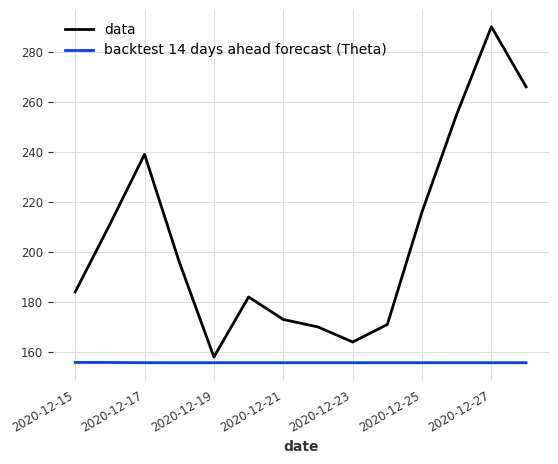

In [25]:
series.slice(pd.Timestamp("20201215"), pd.Timestamp("20201228")).plot(label="data")
forecast.plot(label="backtest 14 days ahead forecast (Theta)")

In [ ]:
from tqdm import tqdm
from darts.metrics import mae, mse, mape

test_from_date = pd.Timestamp("20190101")
model = AutoARIMA()
maes = []
mapes = []
r2s = []
mses = []

for i in tqdm(range(52)):
    train, test = series.split_before(pd.Timestamp(test_from_date))

    model.fit(train)
    forecast = model.predict(14)

    maes.append(mae(test, forecast))
    mapes.append(mape(test, forecast))
    mses.append(mse(test, forecast))
    test_from_date += pd.Timedelta(days=14)

print(test_from_date)
print("MAE = {:.2f}".format(np.mean(maes)))
print("MAPE = {:.2f}".format(np.mean(mapes)))
print("MSE = {:.2f}".format(np.mean(mses)))